<a href="https://colab.research.google.com/github/Nicolas-Noir/AA2-TUIA-2025/blob/main/Practica/AA2_lab4_25_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4 - Predicción de supervivientes del Titanic.

El objetivo de este laboratorio es entrenar un clasificador binario para el dataset de la siguiente competición:

https://www.kaggle.com/c/titanic/overview

Se busca que la salida del modelo sea la probabilidad de supervivencia del pasajero segun los datos de entrada.

## Preparación del entorno.

Si no estamos parados en el repo, clonar y cd al repo. Esto nos permite usar el mismo notebook tanto local como en Google Colab.

In [ ]:
import os

REPO_NAME = "lab4"
if REPO_NAME not in os.getcwd():
  if not os.path.exists(REPO_NAME):
    !git clone https://github.com/FCEIA-AAII/{REPO_NAME}.git
  os.chdir(REPO_NAME)


Importar librerías

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

Establecer GPU por defecto en caso de estar disponible.

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## Análisis exploratorio

In [ ]:
# Cargamos el dataset

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(train_df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


Inspeccionamos cada columna del dataset para entender su significado y valores posibles.

In [ ]:
cols = train_df.columns

for col in cols:
    print("--------------------")
    print("Columna: ", col)
    print("Cantidad de valores nulos: ", train_df[col].isnull().sum())
    print("Cantidad de valores únicos: ", train_df[col].nunique())
    print("Tipo de dato: ", train_df[col].dtype)
    # Si no es numérica, continuar con la siguiente columna
    if train_df[col].dtype == "object":
        print("--------------------")
        continue
    # Si es una columna categórica, mostrar la cantidad de veces que aparece cada valor
    if train_df[col].nunique() < 10:
        print("Valores únicos: ", train_df[col].unique())
        print("Cantidad de veces que aparece cada valor: ", train_df[col].value_counts())
    else:
        # Si es una columna numérica, mostramos media, desvío estándar, mínimo, máximo...
        print("Media: ", train_df[col].mean())
        print("Desvío estándar: ", train_df[col].std())
        print("Mínimo: ", train_df[col].min())
        print("Máximo: ", train_df[col].max())
    print("--------------------")


--------------------
Columna:  PassengerId
Cantidad de valores nulos:  0
Cantidad de valores únicos:  891
Tipo de dato:  int64
Media:  446.0
Desvío estándar:  257.3538420152301
Mínimo:  1
Máximo:  891
--------------------
--------------------
Columna:  Survived
Cantidad de valores nulos:  0
Cantidad de valores únicos:  2
Tipo de dato:  int64
Valores únicos:  [0 1]
Cantidad de veces que aparece cada valor:  Survived
0    549
1    342
Name: count, dtype: int64
--------------------
--------------------
Columna:  Pclass
Cantidad de valores nulos:  0
Cantidad de valores únicos:  3
Tipo de dato:  int64
Valores únicos:  [3 1 2]
Cantidad de veces que aparece cada valor:  Pclass
3    491
1    216
2    184
Name: count, dtype: int64
--------------------
--------------------
Columna:  Name
Cantidad de valores nulos:  0
Cantidad de valores únicos:  891
Tipo de dato:  object
--------------------
--------------------
Columna:  Sex
Cantidad de valores nulos:  0
Cantidad de valores únicos:  2
Tipo de d

Probamos un primer modelo con un subset de features `["Pclass", "sex", "Age"]`.

In [ ]:
# Defino un diccionario para definir el tipo de dato de cada columna
column_types = {
    "Sex": "categoric",
    "Pclass": "categoric",
    "Age": "numeric",
    "Fare": "numeric"
}

# Diccionario para almacenar media y desvío estándar de las columnas numéricas.
# Me va a servir para realizar predicciones en el futuro.
numeric_stats = {}

# Diccionario para almacenar los valores únicos de las columnas categóricas.
# Me va a servir para realizar predicciones en el futuro.
categoric_values = {}

preprocessed_train_df = pd.DataFrame()
preprocessed_test_df = pd.DataFrame()

# Preprocesamiento del set de entrenamiento
for col in column_types.keys():
    if column_types[col] == "categoric":
        num_classes = train_df[col].nunique()
        # Obtengo el one-hot encoding de la columna
        one_hot = pd.get_dummies(train_df[col], prefix=col, dtype=np.float32)
        # Agrego las columnas al dataset preprocesado
        preprocessed_train_df = pd.concat([preprocessed_train_df, one_hot], axis=1)
        # Almaceno los valores únicos
        categoric_values[col] = train_df[col].unique()
    else:
        # Normalizo la columna
        preprocessed_train_df[col] = (train_df[col] - train_df[col].mean()) / train_df[col].std()
        # Almaceno media y desvío estándar
        numeric_stats[col] = {
            "mean": train_df[col].mean(),
            "std": train_df[col].std()
        }

# Agrergo la columna "Survived" al dataset preprocesado
preprocessed_train_df["Survived"] = train_df["Survived"]

# Muestro las primeras filas del dataset preprocesado
print(preprocessed_train_df.head())

# Drop nan values
preprocessed_train_df = preprocessed_train_df.dropna()

# Defino los vectores X_train, y_train, X_test e y_test
X_train = preprocessed_train_df.drop("Survived", axis=1).values.astype(np.float32)
y_train = preprocessed_train_df["Survived"].values.astype(np.float32)

print(X_train.shape, y_train.shape)


   Sex_female  Sex_male  Pclass_1  Pclass_2  Pclass_3       Age      Fare  \
0         0.0       1.0       0.0       0.0       1.0 -0.530005 -0.502163   
1         1.0       0.0       1.0       0.0       0.0  0.571430  0.786404   
2         1.0       0.0       0.0       0.0       1.0 -0.254646 -0.488580   
3         1.0       0.0       1.0       0.0       0.0  0.364911  0.420494   
4         0.0       1.0       0.0       0.0       1.0  0.364911 -0.486064   

   Survived  
0         0  
1         1  
2         1  
3         1  
4         0  
(714, 7) (714,)


Defino un primer modelo y lo entreno.

In [ ]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 801 (3.13 KB)

 Trainable params: 801 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6138 - loss: 0.6923 - val_accuracy: 0.7203 - val_loss: 0.6082
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6597 - loss: 0.6253 - val_accuracy: 0.7762 - val_loss: 0.5501
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6970 - loss: 0.5693 - val_accuracy: 0.7832 - val_loss: 0.5051
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7157 - loss: 0.5317 - val_accuracy: 0.8252 - val_loss: 0.4733
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7478 - loss: 0.5103 - val_accuracy: 0.8322 - val_loss: 0.4503
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7689 - loss: 0.4820 - val_accuracy: 0.8252 - val_loss: 0.4329
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7375 - loss: 0.5282 - val_accuracy: 0.8392 - val_loss: 0.4229
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7919 - loss: 0.4627 - val_accuracy: 0.8322 - 

Experimentar agregando más features y modificando hipermarametros del modelo.

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from sklearn.utils.class_weight import compute_class_weight

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,153 (67.00 KB)

 Trainable params: 17,153 (67.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5356 - loss: 0.6818 - val_accuracy: 0.8042 - val_loss: 0.5856
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7374 - loss: 0.6037 - val_accuracy: 0.8112 - val_loss: 0.4806
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7285 - loss: 0.5518 - val_accuracy: 0.8182 - val_loss: 0.4381
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7465 - loss: 0.5453 - val_accuracy: 0.8252 - val_loss: 0.4177
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7889 - loss: 0.5072 - val_accuracy: 0.8112 - val_loss: 0.4270
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7731 - loss: 0.5026 - val_accuracy: 0.8322 - val_loss: 0.4070
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7892 - loss: 0.4764 - val_accuracy: 0.8182 - val_loss: 0.4194
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7658 - loss: 0.4629 - val_accuracy: 0.839

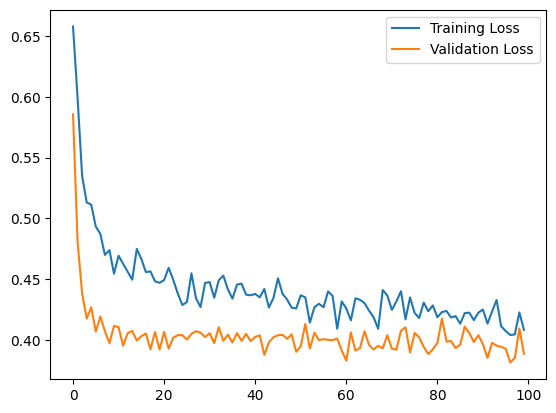

In [ ]:
opt = Adam(learning_rate=0.001)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, batch_size=26, validation_split=0.2,  class_weight=class_weight_dict)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()